In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from numpy import pi
from qiskit.opflow import I, X, Y, Z, MatrixEvolution, PauliTrotterEvolution
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

# Simulating thermal qubits throught thermofield dynamics

### Introduction

This notebook presents a step-by-step explanation on how to implement thermal qubits states using thermofield formalism in Qiskit. In the first section, we start with a simple revision on thermofield dynamics(TFD). After we go over each of the steps of the process of creating a simulation of a thermal qubit on qiskit. After we make a non-thermal qubit be teleported to a thermal reservoir as an application, where the code is provided.

### Thermo Field Dynamics

The Thermo Field Dynamics (TFD) formalism is introduced here for study at finite temperatures.For a thermal equilibrium system, the ensemble average for an operator $ A $ is given by:

\begin{equation}
\langle A\rangle= \frac{1}{Z(\beta)}\text{Tr}(e^{-\beta H}A)\label{avg}    
\end{equation}

However the usual average value of an operator $A$ in quantum theories are given by

$$
\langle A \rangle=\langle n|A|n\rangle
$$

We can define a state $ | 0 (\beta)\rangle $, such that

\begin{equation}
|0(\beta)\rangle = \sum_n \frac{1}{\sqrt{Z(\beta)}}e^{-\beta E_{n}/2}|n,\widetilde{n}\rangle\label{thermostate}
\end{equation}

For a two-level system, we have 

\begin{equation}
|0(\beta)\rangle=\frac{1}{Z(\beta)^{1/2}}\big(|0,\widetilde{0}\rangle+e^{-\beta\frac{\omega}{2}}|1,\widetilde{1}\rangle\big)
\end{equation}

We can rewrite the above equation as
\begin{equation}
|0(\beta)\rangle = a|0,\widetilde{0}\rangle+b|1,\widetilde{1}\rangle.
\end{equation}

This resembles the 2d representation of a qubit
\begin{equation*}
   |q\rangle = \cos{\tfrac{\theta}{2}}|0\rangle + e^{i\phi}\sin{\tfrac{\theta}{2}}|1\rangle,
\end{equation*}
with $\cos{\frac{\theta}{2}}=\frac{1}{\sqrt{1+e^{-\beta\omega}}}$, and $\sin{\frac{\theta}{2}}=\frac{e^{-\beta\omega/2}}{\sqrt{1+e^{-\beta\omega}}}$

Thus, we can represent the thermal vacuum in quantum circuit as

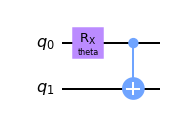

In [2]:
# Define a variable theta to be a parameter with name 'theta'
theta = Parameter('theta')
# Set number of qubits to 2
qubits_count = 2
# Initialize a quantum circuit with one qubit
qc = QuantumCircuit(qubits_count)

# Add a parametrized RX rotation on the qubit
qc.rx(theta,0)
qc.cx(0,1)
qc.draw(output='mpl')
#print(qc)

where we chose φ = 0 for simplicity. 

Considering $\omega=1$ the angle $\theta$ is defined only by the inverse temperature $ \beta $ given the equations

\begin{equation*}
    \begin{aligned}
    \cos\frac{\theta}{2}&=\frac{1}{\sqrt{1+e^{-\beta}}},\\
    \\
    \sin\frac{\theta}{2}&=\frac{1}{\sqrt{1+e^{\beta}}}.
    \end{aligned}
\end{equation*}

This is a thermal qubit.

### Quantum teleport at finite temperature 

In this section we will implement a quantum algorithm to simulate a teleport of a non-thermal qubit into a thermal resevoir in qiskit

First we create the registers

In [3]:
# Creating registers
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(6, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

The TFD-double sates for the teleport circuit between the non-thermal and thermal qubit for $theta=0.705027$, $\beta\approx 2$, is 

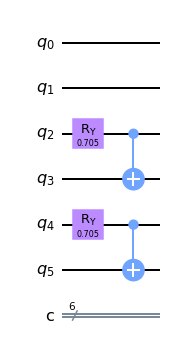

In [4]:
#Prepering the thermal states
theta_value=0.705027
circuit.ry(theta_value, qreg_q[2])
circuit.ry(theta_value, qreg_q[4])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.cx(qreg_q[4], qreg_q[5])
circuit.draw(output='mpl')

The first 2-qubits are used to construct the non-thermal qubit in TFD double formalism, $|00\rangle$. The last four qubits are 2 thermal qubits $|0(\beta)\rangle_1$, $|0(\beta)\rangle_2$.

Now we can apply the teleport circuit between the non-thermal and thermal qubits.

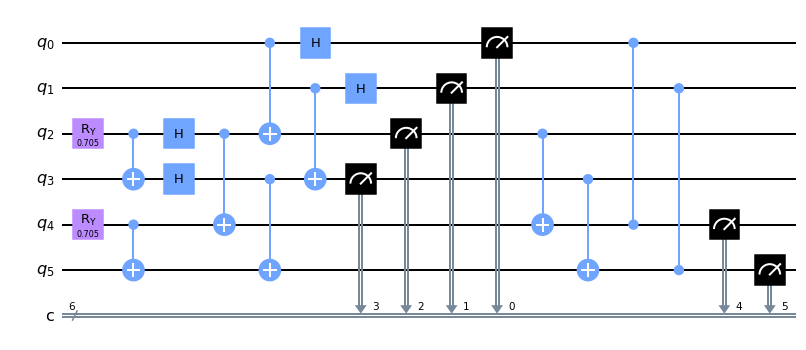

In [5]:
#Prepering the entenglement with the thermal state and the non-thermal state
circuit.h(qreg_q[2])
circuit.cx(qreg_q[2], qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[3])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[3], qreg_q[5])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.h(qreg_q[1])
#Teleporting the non-thermal state into a thermal bath
circuit.measure(qreg_q[3], creg_c[3])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.cx(qreg_q[2], qreg_q[4])
circuit.cz(qreg_q[0], qreg_q[4])
circuit.cx(qreg_q[3], qreg_q[5])
circuit.cz(qreg_q[1], qreg_q[5])
circuit.measure(qreg_q[4], creg_c[4])
circuit.measure(qreg_q[5], creg_c[5])
circuit.draw(output='mpl')

Qiskit teleportation circuit of a non-thermal qubit to a location in thermal bath, were $|q_0,q_1\rangle=|00\rangle$ is the non-thermal qubit.

Now we plot the histogram to have a visualization of the teleported qubit.

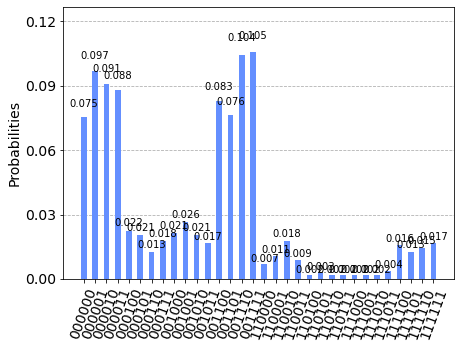

In [6]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator).result()
plot_histogram(result.get_counts(circuit))